---

# Question 2

---

In [84]:
# Python matrix for distances
distances_matrix_w_HTX = [ 
    [0, 343, 163, 367, 526, 443, 589, 735,    614,  269],  # Baton Rouge, LA
    [343, 0, 262, 465, 528, 681, 349, 741,    339,  434],  # Little Rock, AR
    [163, 262, 0, 247, 381, 431, 414, 594,    606,  441],  # Jackson, MS
    [367, 465, 247, 0, 161, 211, 280, 369,    791,  633],  # Montgomery, AL
    [526, 528, 381, 161, 0, 260, 250, 214,    848,  793],  # Atlanta, GA
    [443, 681, 431, 211, 260, 0, 489, 355,    999,  710],  # Tallahassee, FL
    [589, 349, 414, 280, 250, 489, 0, 462,    678,  779],  # Nashville, TN
    [734, 741, 594, 369, 214, 355, 462, 0,    1061, 1002], # Columbia, SC
    [614, 339, 606, 791, 848, 999, 678, 1061, 0,    445],  # Oklahoma City, OK
    [269, 434, 441, 633, 793, 710, 779, 1002, 445,  0]     # Houston, TX
]

# City names corresponding to the rows/columns
cities = {
    0: "Baton Rouge, LA", 
    1: "Little Rock, AR", 
    2: "Jackson, MS", 
    3: "Montgomery, AL",
    4: "Atlanta, GA", 
    5: "Tallahassee, FL", 
    6: "Nashville, TN", 
    7: "Columbia, SC",
    8: "Oklahoma City, OK", 
    #9: "Houston, TX"
}


---

I grabbed the houston data but I'm pretty sure I won't use it.

---

In [85]:
import pandas as pd

# Remove the last row
distances_matrix = distances_matrix_w_HTX[:-1]

# Remove the last element of each row
distances_matrix = [row[:-1] for row in distances_matrix]

# Create a DataFrame from the distances matrix
df_distances = pd.DataFrame(distances_matrix)

# Rename the columns and index to match the city names
df_distances.columns = [cities[i] for i in range(len(df_distances.columns))]
df_distances.index = [cities[i] for i in range(len(df_distances.index))]

display(df_distances)

,"Baton Rouge, LA","Little Rock, AR","Jackson, MS","Montgomery, AL","Atlanta, GA","Tallahassee, FL","Nashville, TN","Columbia, SC","Oklahoma City, OK"
"Baton Rouge, LA",0,343,163,367,526,443,589,735,614
"Little Rock, AR",343,0,262,465,528,681,349,741,339
"Jackson, MS",163,262,0,247,381,431,414,594,606
"Montgomery, AL",367,465,247,0,161,211,280,369,791
"Atlanta, GA",526,528,381,161,0,260,250,214,848
"Tallahassee, FL",443,681,431,211,260,0,489,355,999
"Nashville, TN",589,349,414,280,250,489,0,462,678
"Columbia, SC",734,741,594,369,214,355,462,0,1061
"Oklahoma City, OK",614,339,606,791,848,999,678,1061,0


In [86]:
demand = [4590,
          3055,
          6205,
          5080,
          10912,
          22244,
          7051,
          5282,
          8023]

total_demand = sum(demand)

print(total_demand)

72442


---

Let's create our P-Median Model

---

In [87]:
from gurobipy import Model, GRB, quicksum
import pandas as pd

H = demand

C = distances_matrix

I = range(9) # Demand

J = range(9) # Supply

f = None # we don't need it for this formulation

# DataFrame to hold solutions for each value of p
df_solutions = pd.DataFrame(columns=["p", "Facility", "Assigned Cities", "Total Cost"])

def solve_p_median(p):
    # Create the model
    model = Model("P-Median")

    # Decision variables
    y = model.addVars(I, J, vtype=GRB.BINARY, name="y")   # Assignment variables
    x = model.addVars(J, vtype=GRB.BINARY, name="x")      # Facility location variables

    # Objective function
    model.setObjective(
        quicksum(H[i] * C[i][j] * y[i, j] for i in I for j in J),
        GRB.MINIMIZE
    )

    # Constraints
    # Each city must be assigned to one facility
    model.addConstrs((quicksum(y[i, j] for j in J) == 1 for i in J), name="Assignment")

    # Assignment is only possible to open facilities
    model.addConstrs((y[i, j] <= x[j] for i in I for j in J), name="OpenFacility")

    # Exactly p facilities must be opened
    model.addConstr(quicksum(x[j] for j in J) == p, name="FacilityCount")

    # Solve the model
    model.optimize()

    # Output results
    if model.status == GRB.OPTIMAL:
        print("Optimal solution found:")
        supply_route = []
        total_cost = model.objVal
        for i in I:
            for j in J:
                if y[i, j].x > 0.5:
                    supply_route.append([cities[i], cities[j]])
                    print(f"City {cities[i]} is assigned to facility {cities[j]}.")
        print("Facilities opened at:")
        facilities = []
        for j in J:
            if x[j].x > 0.5:
                facilities.append(cities[j])
                print(f"Facility at {cities[j]}")
        
        # Save results to CSV
        df_facilities = pd.DataFrame(facilities, columns=["City"])
        df_facilities.to_csv(f"hw3-2-a-p{p}.csv", index=False)
        
        # Append results to solutions DataFrame
        df_solutions.loc[len(df_solutions)] = [p, facilities, supply_route, total_cost]
    else:
        print("No optimal solution found.")

    return model

for i in range(1, 5):
    model = solve_p_median(i)


Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[arm] - Darwin 23.6.0 23G93)

CPU model: Apple M2 Max
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 91 rows, 90 columns and 252 nonzeros
Model fingerprint: 0x260866df
Variable types: 0 continuous, 90 integer (90 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [7e+05, 2e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 3.556654e+07
Presolve removed 91 rows and 90 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 2.13576e+07 3.55665e+07 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.135758700000e+07, best bound 2.135758700000e+07, gap 0.0000%
Optimal solution found:
City Baton Rouge, LA is assigned to facility M

In [88]:
import locale

# Set the locale to 'en_US.UTF-8' for currency formatting
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

# Display the df_solutions DataFrame with formatted Total Cost
df_solutions['Total Cost'] = df_solutions['Total Cost'].apply(lambda x: locale.currency(x, grouping=True))
display(df_solutions)

,p,Facility,Assigned Cities,Total Cost
0,1,"[Montgomery, AL]","[[Baton Rouge, LA, Montgomery, AL], [Little Ro...","$21,357,587.00"
1,2,"[Little Rock, AR, Tallahassee, FL]","[[Baton Rouge, LA, Little Rock, AR], [Little R...","$14,164,786.00"
2,3,"[Atlanta, GA, Tallahassee, FL, Oklahoma City, OK]","[[Baton Rouge, LA, Tallahassee, FL], [Little R...","$9,144,098.00"
3,4,"[Jackson, MS, Atlanta, GA, Tallahassee, FL, Ok...","[[Baton Rouge, LA, Jackson, MS], [Little Rock,...","$5,259,558.00"


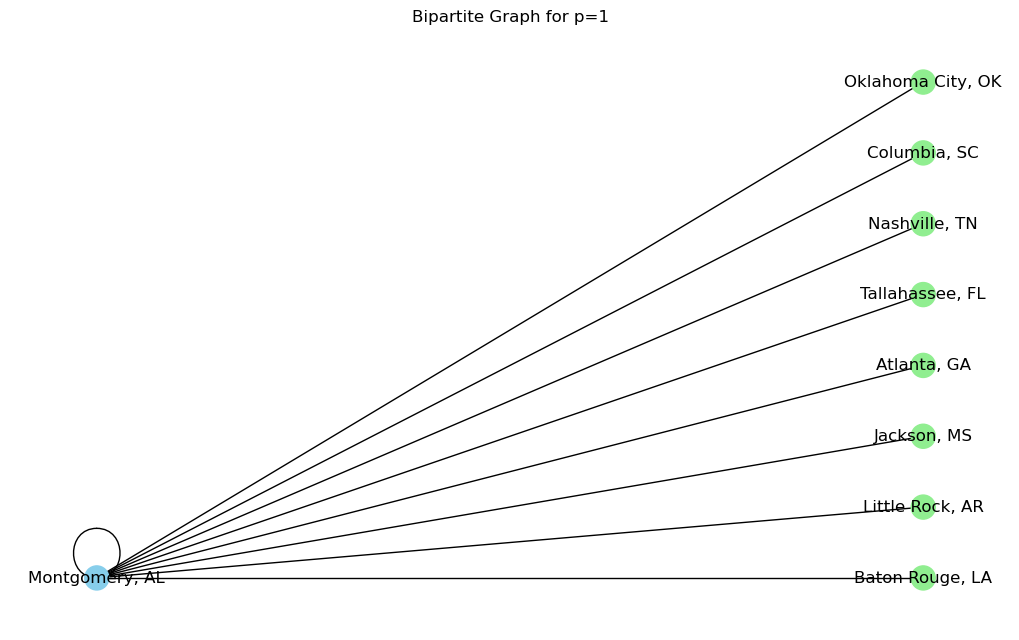

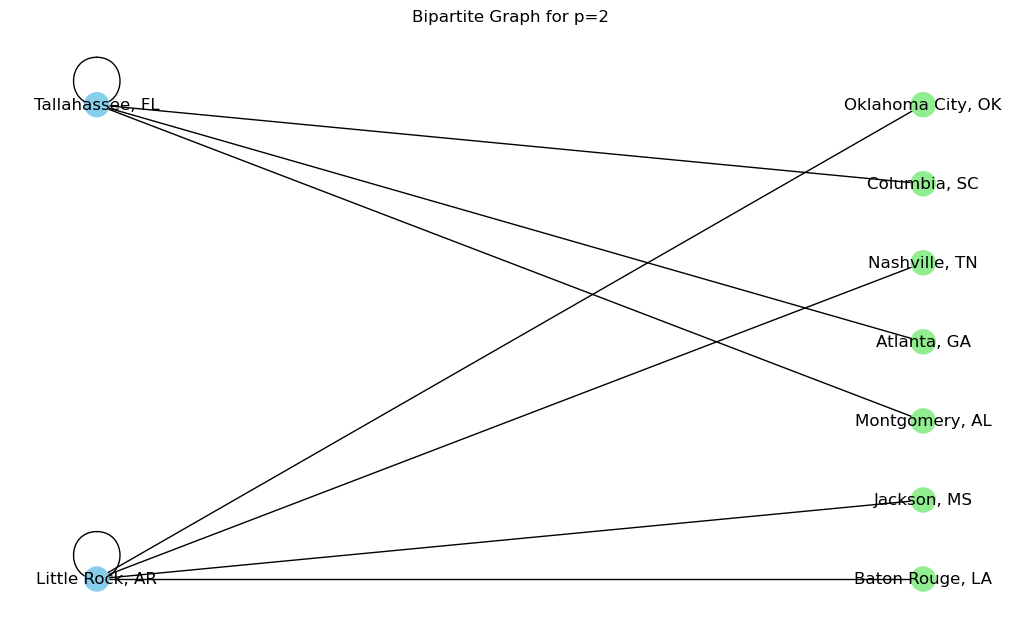

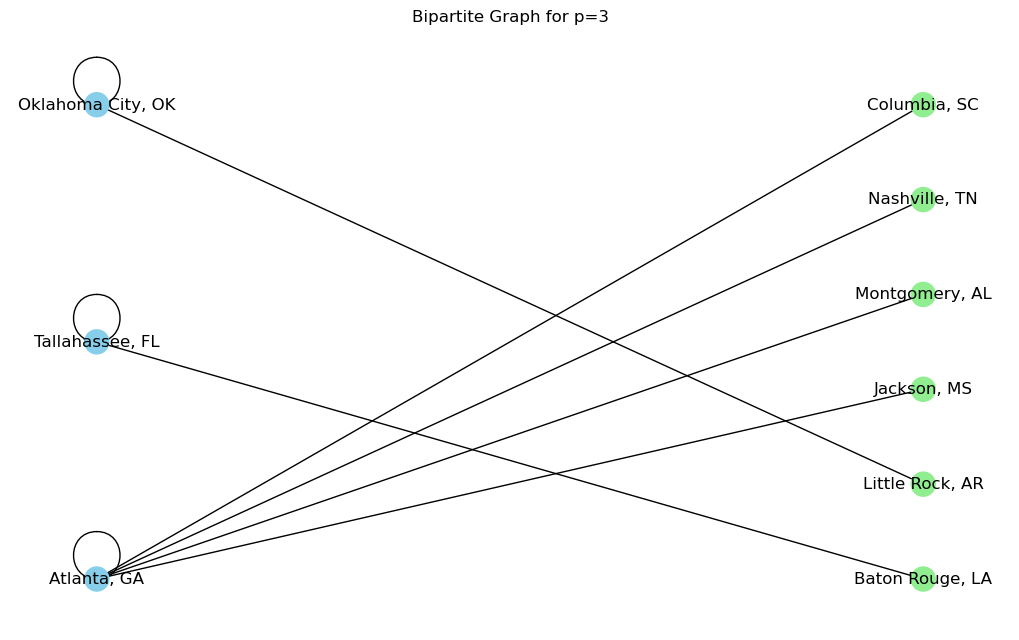

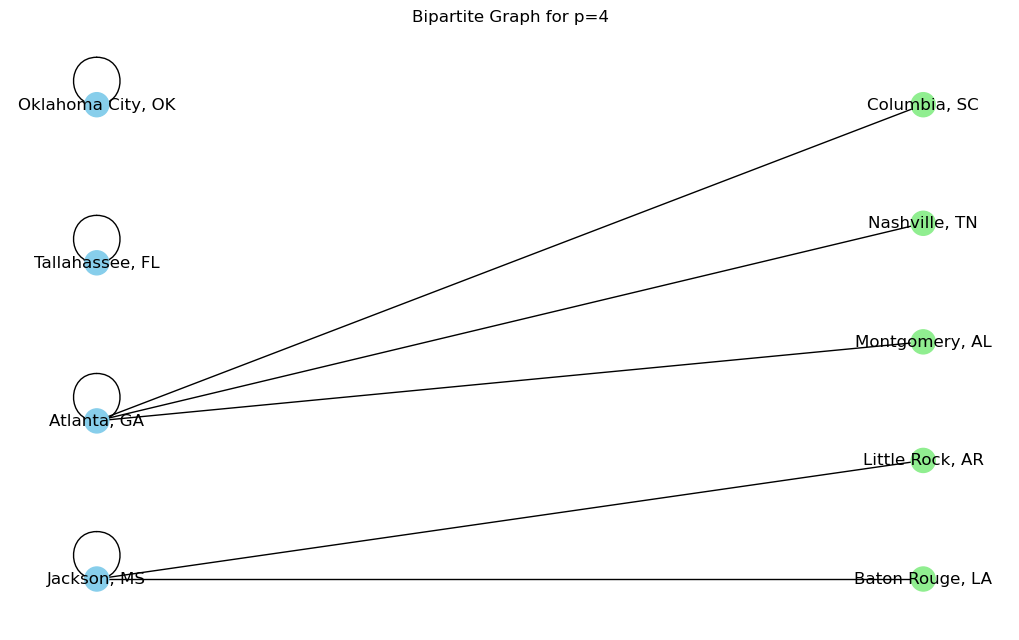

In [89]:
import networkx as nx

import matplotlib.pyplot as plt

def plot_bipartite_graph(df_solutions):
    for index, row in df_solutions.iterrows():
        p = row['p']
        facilities = row['Facility']
        assigned_cities = row['Assigned Cities']
        
        B = nx.Graph()
        
        # Add nodes with the node attribute "bipartite"
        B.add_nodes_from(facilities, bipartite=0)
        B.add_nodes_from([city for city, _ in assigned_cities], bipartite=1)
        
        # Add edges
        for city, facility in assigned_cities:
            B.add_edge(city, facility)
        
        # Draw the bipartite graph
        plt.figure(figsize=(10, 6))
        pos = nx.drawing.layout.bipartite_layout(B, facilities)
        nx.draw(B, pos, with_labels=True, node_color=['skyblue' if node in facilities else 'lightgreen' for node in B.nodes()])
        plt.title(f'Bipartite Graph for p={p}')
        plt.show()

plot_bipartite_graph(df_solutions)

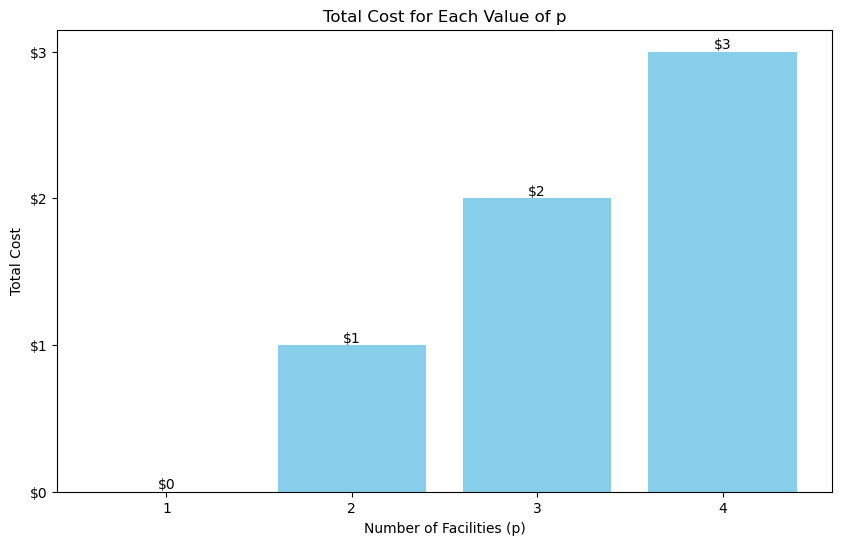

In [90]:
import locale
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Set the locale to 'en_US.UTF-8' for currency formatting
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

# Extract the values of p and the corresponding total costs
p_values = df_solutions['p']
total_costs = df_solutions['Total Cost']

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(p_values, total_costs, color='skyblue')
plt.xlabel('Number of Facilities (p)')
plt.ylabel('Total Cost')
plt.title('Total Cost for Each Value of p')
plt.xticks(p_values)  # Ensure all p values are shown on the x-axis

# Add labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, locale.currency(yval, grouping=True).split('.')[0], ha='center', va='bottom')

# Format y-axis as currency without decimals
formatter = FuncFormatter(lambda x, pos: locale.currency(x, grouping=True).split('.')[0])
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

---

Tekin thought this looked correct.

---